In [1]:
#psychocurves
import glob
import os, sys
os.path.abspath(os.getcwd())
sys.path.append("C:\\Users\\abel_\\Documents\\Rotations\\CIT")
sys.path.append("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\PsychRNN")

import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.init as weight_init

import numpy as np
import numpy.ma as ma
import pickle
import time
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.cm as cmx
import sklearn
import re #

import os
current_dir = os.path.dirname(os.path.realpath('__file__'))
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from psychrnn.tasks.task import Task

from utils import *

C:\Users\abel_\anaconda3\envs\CIT\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [130]:
#load model
#list experiment folders
exp_list = glob.glob(current_dir+"\\experiments\\*")
exp_list = glob.glob(current_dir+"\\experiments\\nrec_limit\\*")
# exp_list = glob.glob(current_dir+"\\experiments\\perceptual_discrimination\\*")
exp_list = sorted(exp_list, key = lambda x: int(x[-10:]))


last_i = 1
exp_path = exp_list[-last_i]
idx = exp_path[-10:]
exp_path

'C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\experiments\\nrec_limit\\Nrec3_1656284823'

In [109]:
with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
    training_kwargs = pickle.load(handle)

training_kwargs['exp_path'] = exp_path
training_kwargs['training_weights_path'] = exp_path+'/training/'
training_kwargs['figures_path'] = exp_path + '//figures/'
idx = int(re.search(r'\d+', exp_path).group())

rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=1, transform_function='relu').to(device)
rnn_model = load_model(rnn_model, training_kwargs)
rnn_model.eval();
exp_path

'C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\experiments\\perceptual_discrimination\\exp_cosineannealing_20_maxepochs200_Nrec3_1656284823'

In [110]:
#set by hand:
# exp_path = 'C:\\Users\\abel_\\Documents\\Rotations\\CIT/experiments/exp_1655115757//'
# with open(exp_path + '/training_kwargs.pickle', 'rb') as handle:
#     training_kwargs = pickle.load(handle)
# idx = int(re.search(r'\d+', exp_path).group())
# rnn_model.load_state_dict(torch.load(train_params['save_weights_path']+'\\weights%s.pth'%idx))

In [111]:
# loss_file_list = [name for name in os.listdir(exp_path) if name[-4:]=='.txt']
# for file in loss_file_list:
#     losses = np.loadtxt(exp_path + file, delimiter=',')
#     plt.plot(losses)
# plt.ylim([0,1])
# plt.xlabel("Time", fontsize=12)
# plt.ylabel("Loss", fontsize=12);

In [112]:
max_coh = 0.05
coherence_list = np.linspace(.0, max_coh, 51)
# N_test_batch = 10000
# pd = PerceptualDiscrimination(dt=10, tau=100, T=2000, N_batch=N_test_batch, coherence_list = coherence_list)
# test_x, test_y, test_output_mask, test_trial_params = pd.get_trial_batch() #generate self.N_batch trials
# test_set = [test_x, test_y, test_output_mask, test_trial_params]
# with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\data_cohs0_0.25.pickle", 'wb') as handle:
#     pickle.dump(test_set, handle, protocol=pickle.HIGHEST_PROTOCOL)
if max_coh == 0.05:
    with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\data_cohs0_0.05.pickle", 'rb') as handle:
        test_set = pickle.load(handle)
elif max_coh == 0.25:
    with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\data_cohs0_0.25.pickle", 'rb') as handle:
        test_set = pickle.load(handle)
test_x, test_y, test_output_mask, test_trial_params = test_set

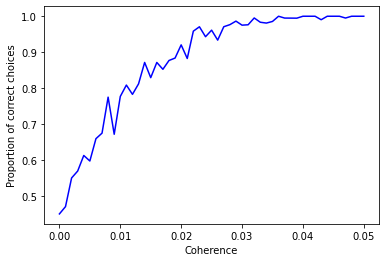

In [113]:
#accuracy vs coherence, with direction
inputs = torch.tensor(test_x, dtype=torch.float)
yhat, hidden = rnn_model(inputs)
yhat_np = yhat.detach().numpy()
_, average_accuracy_per_coherence = get_correctness_curve(test_y, yhat_np, test_output_mask, test_trial_params)
plt.figure(figsize=(6,4))
ax = plt.subplot(111)
plt.plot(coherence_list, average_accuracy_per_coherence, 'b')
ax.set_xlabel("Coherence")
ax.set_ylabel("Proportion of correct choices")
# print("Accuracy:", pd.accuracy_function(test_y, yhat_np, test_output_mask))
plt.savefig(training_kwargs['figures_path'] + "/correct_%s.pdf"%idx)

In [114]:
# model_file_list = [name for name in os.listdir(exp_path) if name[-4:]=='.pth']
# for file in model_file_list[:]:
#     idx = int(re.search(r'\d+', file).group())
#     # rnn_model = RNNModel() # we do not specify pretrained=True, i.e. do not load default weights
#     rnn_model.load_state_dict(torch.load(exp_path + file))
#     rnn_model.eval()
#     # test_x, test_y, test_output_mask, test_trial_params
#     inputs = torch.tensor(test_x, dtype=torch.float)
#     yhat, hidden = rnn_model(inputs)
#     yhat_np = yhat.detach().numpy()
#     print("Accuracy:", pd.accuracy_function(test_y, yhat_np, test_output_mask))
    
#     all_directed_coherences, average_accuracy_per_coherence = get_psycho_curve(test_y, yhat_np, test_output_mask, test_trial_params)
#     plt.figure(figsize=(6,4))
#     ax = plt.subplot(111)
#     plt.plot(all_directed_coherences, average_accuracy_per_coherence, 'b')
#     ax.set_xlabel("Coherence")
#     ax.set_ylabel("Choice")
#     ax.set_yticks([-1,1]);
#     plt.savefig(train_params['figures_path'] + "/psycho_%s.pdf"%idx)
#     plt.close()
# # plt.ylim([0,1])

In [115]:
output_mask = test_output_mask
trial_params = test_trial_params
yhat = yhat_np
y = test_y
coherence_array = np.array([trial_params[i]['coherence'] for i in range(trial_params.size)])
direction_array = np.array([trial_params[i]['direction'] for i in range(trial_params.size)])
directed_coherence_array = coherence_array * (-1.)**direction_array

chosen = np.argmax(np.mean(yhat*output_mask, axis=1), axis = 1)
truth = np.argmax(np.mean(y*output_mask, axis = 1), axis = 1)
response_correctness = np.equal(truth, chosen)
all_coherences = np.unique(coherence_array)
average_accuracy_per_coherence = np.array([np.mean(response_correctness[np.where(coherence_array == coherence)]) for coherence in all_coherences])

# left_trials = np.where(direction_array==0.)
# right_trials = np.where(direction_array!=0.)
# left_responses = chosen[np.where(direction_array==0.)]
# right_responses = chosen[np.where(direction_array!=0.)]

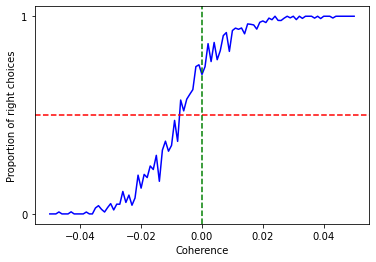

In [117]:
plt.figure(figsize=(6,4))
ax = plt.subplot(111)
all_directed_coherences, average_accuracy_per_coherence = get_psycho_curve(test_y, yhat_np, test_output_mask, test_trial_params)
plt.plot(all_directed_coherences, 1-average_accuracy_per_coherence, 'b')
# ax.plot(all_coherences, average_accuracy_per_coherence_left, 'b')
# ax.plot(-all_coherences, average_accuracy_per_coherence_right, 'b')
ax.set_xlabel("Coherence")
ax.set_ylabel("Proportion of right choices")
ax.set_yticks([0,1])
ax.axhline(y = 0.5, color = 'r', linestyle = '--')
ax.axvline(x = 0, color = 'g', linestyle = '--')
plt.savefig(training_kwargs['figures_path'] + "/psycho_%s.pdf"%idx)

In [118]:
max_coh = 0.05
coherence_list = [0.01, 0.02, 0.03]
test_kwargs = training_kwargs 
test_kwargs['coherence_list'] = coherence_list
test_kwargs['coherence'] = None
N_test_batch = 50000
# pd = PerceptualDiscrimination(N_batch=N_test_batch, training_kwargs=test_kwargs)
# test_x, test_y, test_output_mask, test_trial_params = pd.get_trial_batch() #generate self.N_batch trials
# test_set = [test_x, test_y, test_output_mask, test_trial_params]

# with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\test_set_chrono.pickle", 'wb') as handle:
#     pickle.dump(test_set, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\test_set_chrono.pickle", 'rb') as handle:
    test_set = pickle.load(handle)

In [119]:
inputs = torch.tensor(test_x, dtype=torch.float)
yhat, hidden = rnn_model(inputs)
yhat = yhat.detach().numpy()

In [120]:
import pandas
from scipy.stats import t

data_params_dict = test_trial_params
trial_params = test_trial_params
output_mask = test_output_mask
y = test_y
[params.update({"trial":yhat[i,:,:]}) for i,params in enumerate(trial_params)]
# 
v = {k: [dic[k] for dic in data_params_dict] for k in data_params_dict[0]}
pd = pandas.DataFrame(v)
np.where(pd['coherence'] != 0)[0]

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=int64)

In [121]:
chosen = np.argmax(np.mean(yhat*output_mask, axis=1), axis = 1)
truth = np.argmax(np.mean(y*output_mask, axis = 1), axis = 1)
response_correctness = np.equal(truth, chosen)
#can be added to dataframe: correctness.

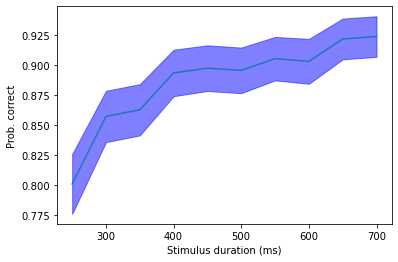

In [122]:
#trying to replicate a figure along the lines of Fig 1 E in Brunton 2013
#however stimulus duration does not take discrete values
# The vertical axis shows mean accuracy and 95% confidence interval (CI).

stim_durations = [test_trial_params[i]['stim_duration'] for i in range(len(test_trial_params))]
# plt.hist(stim_durations); #looks uniform as defined

#solution 1: average per discrete duration class
perbin, bin_boundaries = np.histogram(stim_durations)
pcorr_list = []
stcorr_list = []
ci_list = []
for i,bb in enumerate(bin_boundaries[:-1]):
    disc_dur_idx = np.where((bb<=stim_durations) & (stim_durations<bin_boundaries[i+1]))[0]
    coh_not0 = np.where(pd['coherence'] != 0)[0]
    intersection = [idx for idx in disc_dur_idx if idx in coh_not0]
    x = response_correctness[intersection]
    pcorr = np.mean(x)
    stcorr = np.std(x)
    pcorr_list.append(pcorr)
    stcorr_list.append(stcorr)

    dof = len(x)-1 
    confidence = 0.95
    t_crit = np.abs(t.ppf((1-confidence)/2,dof))
    ci_list.append((pcorr-stcorr*t_crit/np.sqrt(len(x)), pcorr+stcorr*t_crit/np.sqrt(len(x))))

plt.plot(bin_boundaries[:-1], pcorr_list)
ci = np.array(ci_list)
# plt.errorbar(bin_boundaries[:-1], pcorr_list, yerr=np.array(ci_list).T)
plt.fill_between(bin_boundaries[:-1], ci[:,0], ci[:,1], color='blue', alpha=0.5)
plt.xlabel("Stimulus duration (ms)")
plt.ylabel("Prob. correct")

plt.savefig(training_kwargs['figures_path'] + "chronometric_all.pdf")

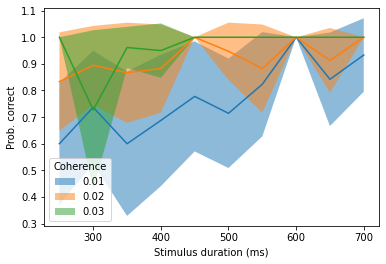

In [123]:
#trying to replicate a figure along the lines of Fig 1 E in Brunton 2013
#however stimulus duration does not take discrete values
# The vertical axis shows mean accuracy and 95% confidence interval (CI).
coherence_list = [.01, .02, .03]

stim_durations = [test_trial_params[i]['stim_duration'] for i in range(len(test_trial_params))]
# plt.hist(stim_durations); #looks uniform as defined

#solution 1: average per discrete duration class
perbin, bin_boundaries = np.histogram(stim_durations)

fig, ax = plt.subplots()
plines = []
pfills = []
for coh_i,coherence in enumerate(coherence_list):
    pcorr_list = []
    stcorr_list = []
    ci_list = []
    coh_idx = np.where(pd['coherence']==coherence)[0]
    for i,bb in enumerate(bin_boundaries[:-1]):
        disc_dur_idx = np.where((bb<=stim_durations) & (stim_durations<bin_boundaries[i+1]))[0]
        intersection = [idx for idx in disc_dur_idx if idx in coh_idx]
        x = response_correctness[intersection]
        pcorr = np.mean(x)
        stcorr = np.std(x)
        pcorr_list.append(pcorr)
        stcorr_list.append(stcorr)

        dof = len(x)-1 
        confidence = 0.95
        t_crit = np.abs(t.ppf((1-confidence)/2,dof))
        ci_list.append((pcorr-stcorr*t_crit/np.sqrt(len(x)), pcorr+stcorr*t_crit/np.sqrt(len(x))))

    ci = np.array(ci_list)
    plines.append(ax.plot(bin_boundaries[:-1], pcorr_list))
    pfills.append(ax.fill_between(bin_boundaries[:-1], ci[:,0], ci[:,1], alpha=0.5, label = str(coherence)))
    # ax.errorbar(bin_boundaries[:-1], pcorr_list, yerr=np.abs(ci.T-pcorr_list), label = str(coherence))
    
i = 0
# ax.legend([(plines[i][0], pfills[i][0]), ], ['Stuff'])
plt.xlabel("Stimulus duration (ms)")
plt.ylabel("Prob. correct")
ax.legend(title='Coherence')
plt.savefig(training_kwargs['figures_path'] + "chronometric_fill.pdf")

In [124]:
#solution 2: create test set with discrete durations
training_kwargs['stim_durations'] = list(np.linspace(150, 750, 7))

# max_coh = 0.05
# coherence_list = [0.01, 0.02, 0.03]
# test_kwargs = training_kwargs 
# test_kwargs['coherence_list'] = coherence_list
# test_kwargs['coherence'] = None
# N_test_batch = 50000
# pd = PerceptualDiscrimination(N_batch=N_test_batch, training_kwargs=test_kwargs)
# test_x, test_y, test_output_mask, test_trial_params = pd.get_trial_batch() #generate self.N_batch trials
# test_set = [test_x, test_y, test_output_mask, test_trial_params]

# with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\test_set_chrono_stimdur.pickle", 'wb') as handle:
    # pickle.dump(test_set, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\test_set_chrono_stimdur.pickle", 'rb') as handle:
    test_set = pickle.load(handle)
    
test_x, test_y, test_output_mask, test_trial_params = test_set

In [125]:
inputs = torch.tensor(test_x, dtype=torch.float)
yhat, hidden = rnn_model(inputs)
yhat = yhat.detach().numpy()

data_params_dict = test_trial_params
trial_params = test_trial_params
output_mask = test_output_mask
y = test_y

chosen = np.argmax(np.mean(yhat*output_mask, axis=1), axis = 1)
truth = np.argmax(np.mean(y*output_mask, axis = 1), axis = 1)
response_correctness = np.equal(truth, chosen)

In [126]:
[params.update({"trial":yhat[i,:,:]}) for i,params in enumerate(trial_params)]
# 
v = {k: [dic[k] for dic in data_params_dict] for k in data_params_dict[0]}
pd = pandas.DataFrame(v)
stim_durations = np.unique(pd['stim_duration'])
coherence_list = np.unique(pd['coherence'])
stim_durations

array([150., 250., 350., 450., 550., 650., 750.])

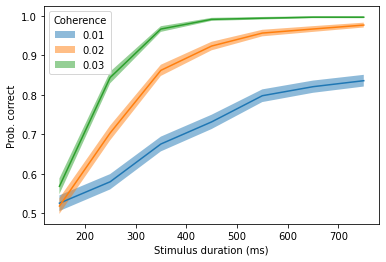

In [127]:
#same as above but with fixed stimulus durations (random from list)
fig, ax = plt.subplots()
plines = []
pfills = []
for coh_i,coherence in enumerate(coherence_list):
    pcorr_list = []
    stcorr_list = []
    ci_list = []
    coh_idx = np.where(pd['coherence']==coherence)[0]
    for i, stim_duration in enumerate(stim_durations):
        disc_dur_idx = np.where(pd['stim_duration'] == stim_duration)[0]
        intersection = [idx for idx in disc_dur_idx if idx in coh_idx]
        x = response_correctness[intersection]
        # print(x.shape)
        pcorr = np.mean(x)
        stcorr = np.std(x)
        pcorr_list.append(pcorr)
        stcorr_list.append(stcorr)

        #calculate 95% confidence intervals
        dof = len(x)-1 
        confidence = 0.95
        t_crit = np.abs(t.ppf((1-confidence)/2,dof))
        ci_list.append((pcorr-stcorr*t_crit/np.sqrt(len(x)), pcorr+stcorr*t_crit/np.sqrt(len(x))))

    ci = np.array(ci_list)
    plines.append(ax.plot(stim_durations, pcorr_list))
    pfills.append(ax.fill_between(stim_durations, ci[:,0], ci[:,1], alpha=0.5, label = str(coherence)))
    # ax.errorbar(bin_boundaries[:-1], pcorr_list, yerr=np.abs(ci.T-pcorr_list), label = str(coherence))
    
plt.xlabel("Stimulus duration (ms)")
plt.ylabel("Prob. correct")
ax.legend(title='Coherence')
plt.savefig(training_kwargs['figures_path'] + "chronometric_stimdur_fill.pdf")

In [128]:
exp_list = glob.glob(current_dir+"\\experiments\\*")
exp_list = [exp_list[i] for i in range(len(exp_list)) if exp_list[i][-1].isdigit()]
exp_list = sorted(exp_list, key = lambda x: int(x[-10:]))
# exp_list

In [129]:
for exp_path in exp_list:
    try:
        with open(exp_path + '/training_kwargs.pickle', 'rb') as handle:
            training_kwargs = pickle.load(handle)

            if training_kwargs['transform_function'] == 'tanh':
                print(exp_path)
                break
            
    except:
        0